In [37]:
import numpy as np
import os
from scipy import stats
import scipy.integrate as integrate
import tensorflow as tf

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

np.random.seed(666)
eps = 1e-7

In [38]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [39]:
g = np.meshgrid(np.linspace(-1.5, 1.5, 301), np.linspace(-1.5, 1.5, 301))
g = np.round(np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1), 3)

In [40]:
# Empiric estimation of losses

N = 5 * 10**5
bkgd = stats.norm.rvs(-0.1, 1, size = N)
sgnl = stats.norm.rvs(+0.1, 1, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

def bce(a, b):
    cfr = lambda x: sig(a*x + b)
    y_hat = cfr(X)
    return -np.mean( np.log(y_hat[y == 1] + eps) + np.log(1 - y_hat[y == 0] + eps) )
    #return np.mean(-( (y) * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps) ))

def mse(a, b):
    cfr = lambda x: sig(a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 - y_hat[y == 1])**2 + -(y_hat[y == 0])**2 )
    #return np.mean(-( (y) * -(1 - y_hat)**2 + (1 - y) * -(y_hat)**2 ))

def mse_p(a, b, p):
    cfr = lambda x: sig(a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 - y_hat[y == 1])**p + -(y_hat[y == 0])**p )

def mlc(a, b):
    cfr = lambda x: relu(a*x + b)
    y_hat = cfr(X)
    return -np.mean( np.log(y_hat[y == 1] + eps) + (1 - y_hat[y == 0]) )
    #return np.mean(-( (y) * np.log(y_hat + eps) + (1 - y) * (1 - y_hat)))

def exp_mlc(a, b):
    cfr = lambda x: relu(a*x + b)
    y_hat = cfr(X)
    return -np.mean( y_hat[y == 1] + (1 - np.exp(y_hat[y == 0])) )

def sqr(a, b):
    cfr = lambda x: np.maximum(0, a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 / (y_hat[y == 1] + eps)**0.5) + -(y_hat[y == 0])**0.5 )
    #return np.mean(-( (y) * -(1 / (y_hat + eps)**0.5) + (1 - y) * -(y_hat)**0.5 ))

def exp_sqr(a, b):
    cfr = lambda x: np.maximum(0, a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 / (np.exp(y_hat[y == 1]))**0.5) + -(np.exp(y_hat[y == 0]))**0.5 )

def sqr_r(a, b, r):
    cfr = lambda x: np.maximum(0, a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 / (y_hat[y == 1] + eps)**(r/2)) + -(y_hat[y == 0])**(r/2) )

In [41]:
# Numerical estimation of losses

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad(g, -np.inf, np.inf)[0]

def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad(g, -np.inf, np.inf)[0]

def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad(g, -np.inf, np.inf)[0]

def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad(g, -np.inf, np.inf)[0]

# Basic Run

## Running

In [ ]:
nsqr_zs = np.zeros(g.shape[0])

for i in range(g.shape[0])
    p = g[i]
    bce_zs[i] = 

In [ ]:
%%time

bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []

i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

bce_zs = np.array(bce_zs)
mse_zs = np.array(mse_zs)
mlc_zs = np.array(mlc_zs)
sqr_zs = np.array(sqr_zs)

In [ ]:
np.save('anims/bce_zs_2', bce_zs)
np.save('anims/mse_zs_2', mse_zs)
np.save('anims/mlc_zs_2', mlc_zs)
np.save('anims/sqr_zs_2', sqr_zs)
np.save('anims/grid_2', g)

In [ ]:
%%time
# Numerical estimation
nbce_zs = []
nmse_zs = []
nmlc_zs = []
nsqr_zs = []

i = 0
for p in g:
    nbce_zs += [nbce(p[0], p[1])]
    nmse_zs += [nmse(p[0], p[1])]
    nmlc_zs += [nmlc(p[0], p[1])]
    nsqr_zs += [nsqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', nbce_zs[-1], nmse_zs[-1], nmlc_zs[-1], nsqr_zs[-1]) 
    i += 1

nbce_zs = np.array(nbce_zs)
nmse_zs = np.array(nmse_zs)
nmlc_zs = np.array(nmlc_zs)
nsqr_zs = np.array(nsqr_zs)

In [ ]:
np.save('anims/nbce_zs', nbce_zs)
np.save('anims/nmse_zs', nmse_zs)
np.save('anims/nmlc_zs', nmlc_zs)
np.save('anims/nsqr_zs', nsqr_zs)
np.save('anims/ngrid', g)

## Examining

In [6]:
g = np.load('anims/grid_2.npy')
bce_zs = np.load('anims/bce_zs_2.npy')
mse_zs = np.load('anims/mse_zs_2.npy')
mlc_zs = np.load('anims/mlc_zs_2.npy')
sqr_zs = np.load('anims/sqr_zs_2.npy')

nbce_zs = np.load('anims/nbce_zs.npy')
nmse_zs = np.load('anims/nmse_zs.npy')
nmlc_zs = np.load('anims/nmlc_zs.npy')
nsqr_zs = np.load('anims/nsqr_zs.npy')

In [7]:
print('Empirical Estimation')
print(g[bce_zs == min(bce_zs)])
print(g[mse_zs == min(mse_zs)])
print(g[mlc_zs == min(mlc_zs)])
print(g[sqr_zs == min(sqr_zs)])
print()
print('Numerical Estimation')
print(g[nbce_zs == min(nbce_zs)])
print(g[nmse_zs == min(nmse_zs)])
print(g[nmlc_zs == min(nmlc_zs)])
print(g[nsqr_zs == min(nsqr_zs)])

Empirical Estimation
[[0.2 0. ]]
[[0.2 0. ]]
[[0.19 1.02]]
[[0.19 1.02]]

Numerical Estimation
[[0.2 0. ]]
[[0.2 0. ]]
[[0.19 1.02]]
[[0.15 1.02]]


In [8]:
print('Empirical')
print(mlc(0.19, 1.02), mlc(0.15, 1.02))
print()
print('Numerical')
print(nmlc(0.19, 1.02), nmlc(0.15, 1.02))

Empirical
-0.01959666953392953 -0.018557053898949405

Numerical
-0.019582900384103027 -0.0185423498368625


In [9]:
print('Empirical')
print(sqr(0.19, 1.02), sqr(0.15, 1.02))
print()
print('Numerical')
print(nsqr(0.19, 1.02), nsqr(0.15, 1.02))

Empirical
1.9902344667269418 1.990716665293662

Numerical
3.513820114922155 1.9908976302526822


In [10]:
g.shape

(90601, 2)

In [11]:
len(nbce_zs)

90601

# Plot All

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

In [ ]:
nbce_zs = np.load('anims/nbce_zs.npy')
nmse_zs = np.load('anims/nmse_zs.npy')
nmlc_zs = np.load('anims/nmlc_zs.npy')
nsqr_zs = np.load('anims/nsqr_zs.npy')

In [ ]:
x_min = g[nbce_zs == min(nbce_zs)][:, 0]
y_min = g[nbce_zs == min(nbce_zs)][:, 1]
z_min = nbce_zs[nbce_zs == min(nbce_zs)]

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, nbce_zs, s = 5, c = nbce_zs, cmap = 'viridis')
ax.scatter(
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = nbce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, nmse_zs, s = 5, c = nmse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = nmse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, nmlc_zs, s = 5, c = nmlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = nmlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, nsqr_zs, s = 5, c = nsqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = nsqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

# Rotating Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'BCE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=False)  
ani.save('anims/bce_2.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MSE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mse.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mlc.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/sqr.gif')

# Static Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

#plt.savefig('plots/scratch/bce_landscape_100.png',
#            dpi=1200, 
#            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = bce_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/bce_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mse_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mlc_zs, c = mlc_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mlc_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, sqr_zs, c = sqr_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = sqr_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

# Shifting Gaussians

## BCE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [bce(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.savefig('anims/shift/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    i += 1

## MSE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mse(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 1)
    plt.savefig('anims/shift/mse/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## MLC

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mlc(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 38)
    plt.savefig('anims/shift/mlc/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [sqr(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/shift/sqr/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $A/B$ Parametrizations

## MSE

In [ ]:
ps = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for p in ps:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [mse_p(pt[0], pt[1], p)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 5)
    plt.savefig('anims/mse_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
rs = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for r in rs:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [sqr_r(pt[0], pt[1], r)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/sqr_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $C$ Parametrizations

## MLC

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_mlc_zs, s = 5, c = exp_mlc_zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_mlc_2.gif')

## SQR

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_sqr_zs, s = 5, c = exp_sqr_zs, cmap = 'viridis')
    ax.set_zlim(1.5, 6)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_sqr_2.gif')

# Gamma Landscapes

In [ ]:
N = 5 * 10**3
bkgd = stats.gamma.rvs(5, 1, size = N)
sgnl = stats.gamma.rvs(6, 1, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Betas

In [ ]:
N = 5 * 10**3
bkgd = stats.beta.rvs(2, 3, size = N)
sgnl = stats.beta.rvs(3, 2, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

g = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
g = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis = 1)

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Scratch

In [46]:
import numpy as np
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt

In [47]:
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)
#eps = np.finfo(float).eps
eps = 1e-7

In [48]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [49]:
# Numerical estimation of losses

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

@np.vectorize
def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad(g, -np.inf, np.inf)[0]

def vbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

In [50]:
aa, bb = np.meshgrid(np.linspace(-1.5, 1.5, 21), np.linspace(-1.5, 1.5, 21))

In [51]:
vvc = vbce(aa, bb)
vvs = vmse(aa, bb)
vvl = vmlc(aa, bb)
vvq = vsqr(aa, bb)

/tmp/ipykernel_20664/1171388478.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [52]:
nnc = nbce(aa, bb)
nns = nmse(aa, bb)
nnl = nmlc(aa, bb)
nnq = nsqr(aa, bb)

/tmp/ipykernel_20664/1171388478.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [53]:
np.max(vvc - nnc), np.max(vvs - nns), np.max(vvl - nnl), np.max(vvq - nnq)

(2.220446049250313e-15,
 1.1102230246251565e-15,
 1.6615411269071956e-07,
 2.17107681237394e-05)

# The Issue


In [54]:
eps = np.finfo(float).eps

In [55]:
fa = 0.19
fb = 1.02
f = lambda x: -(sgnl.pdf(x) * -1 / (relu(fa*x + fb) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(fa*x + fb)**0.5 )

In [56]:
ha = 0.15
hb = 1.02
h = lambda x: -(sgnl.pdf(x) * -1 / (relu(ha*x + hb) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(ha*x + hb)**0.5 )

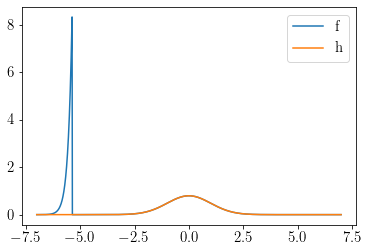

In [57]:
xs = np.linspace(-7, 7, 1000)
plt.plot(xs, f(xs), label = 'f')
plt.plot(xs, h(xs), label = 'h')
plt.legend();

In [58]:
-hb / ha

-6.800000000000001

In [59]:
-fb / fa

-5.368421052631579

In [60]:
x = xs[f(xs) == np.max(f(xs))]

In [61]:
x

array([-5.37437437])

In [62]:
sgnl.pdf(x)

array([1.23957642e-07])

In [63]:
1 / (relu(ha*x + hb) + eps)**0.5

array([2.16247763])

In [64]:
1 / (relu(fa*x + fb) + eps)**0.5

array([67108864.])

In [65]:
eps = 1e-11

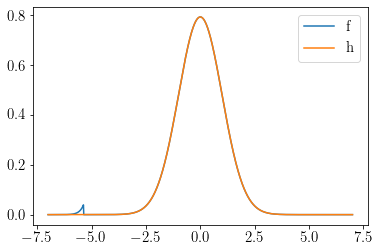

In [66]:
xs = np.linspace(-7, 7, 1000)
plt.plot(xs, f(xs), label = 'f')
plt.plot(xs, h(xs), label = 'h')
plt.legend();

# Vectorization

## Method 1: Numpy Vectorization

A one-dimensional example.

In [67]:
fun2int = lambda x, a: np.sqrt(x+a)
intfun = lambda a: integrate.quad(fun2int, 0, 4, args=(a))[0]
vec_int = np.vectorize(intfun)
vec_int(np.linspace(0,2,5))

array([5.33333333, 6.12825877, 6.78689326, 7.37435069, 7.91234089])

While this doesn't speed up performance, it is convenient. It also allows for interval modifying based on the input.

In [68]:
j = lambda x, a, b: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                      bkgd.pdf(x) * -relu(a*x + b)**0.5 )
t = lambda a, b: integrate.quad(j, a == 0 and -np.inf or -b/a, np.inf, args=(a, b))[0]
vec_t = np.vectorize(t)

In [69]:
vec_t([-1, 0, 1], [0, 1, 2])

array([1.70708551e+05, 2.00000000e+00, 2.08912421e+00])

In [70]:
vec_t([-1, 0, 1], 0)

array([1.70708551e+05, 3.16227766e+05, 1.26805043e+00])

In [71]:
vec_t([-1, 0, 1], 1)

array([5.82049223e+04, 2.00000000e+00, 1.84533118e+00])

In [72]:
vec_t([-1, 0, 1], 2)

array([9.08097356e+03, 2.12132034e+00, 2.08912421e+00])

In [73]:
vec_t([[-1, 0, 1], [-1, 0, 1]], [[-1, -1, -1], [0, 0, 0]])

array([[2.73326391e+05, 3.16227766e+05, 4.94676570e-01],
       [1.70708551e+05, 3.16227766e+05, 1.26805043e+00]])

In [74]:
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 11), np.linspace(-1.5, 1.5, 11))
#g = np.round(np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1), 3)

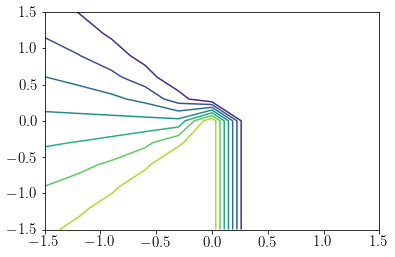

In [75]:
plt.contour(X, Y, vec_t(X, Y))

## Method 2: quad_vec

This results in a speed-up, but it doesn't allow us to modify the interval based on the values of $a$ and $b$. We would have to tune epsilon instead.

In [77]:
np.array([[a, b] for a in [-1, 0, 1] for b in [-1, 0, 1]]).reshape(-1)

array([-1, -1, -1,  0, -1,  1,  0, -1,  0,  0,  0,  1,  1, -1,  1,  0,  1,
        1])

In [78]:
aa = [-1, 0, 1]
bb = [-1, 0, 1]
f = lambda x: np.array([bkgd.pdf(x) * -relu(a*x + b)**0.5 for a in aa for b in bb])

In [79]:
integrate.quad_vec(f, -np.inf, np.inf)

(array([-0.12331811, -0.45508213, -0.95070205,  0.        ,  0.        ,
        -1.        , -0.08730651, -0.36914971, -0.8499692 ]),
 2.054789613586759e-09)

In [80]:
a, b = np.meshgrid([-1, 0, 1], [-1, 0, 1])
f = lambda x: 1 / (1 + np.exp(a*x**2 + b))

In [81]:
f(1)

array([[0.88079708, 0.73105858, 0.5       ],
       [0.73105858, 0.5       , 0.26894142],
       [0.5       , 0.26894142, 0.11920292]])

In [ ]:
integrate.quad_vec(f, -np.inf, np.inf)

/tmp/ipykernel_20664/97824040.py:2: RuntimeWarning: overflow encountered in exp
  f = lambda x: 1 / (1 + np.exp(a*x**2 + b))


(array([[9.14725280e+153, 6.68717763e+153, 1.82041136e+000],
        [9.14725280e+153, 4.57362640e+153, 1.07215493e+000],
        [9.14725280e+153, 2.46007517e+153, 5.21150383e-001]]),
 nan)

In [ ]:
(bkgd.pdf(1) + relu(a*1 + b)).reshape(-1).reshape(a.shape)

array([[0.21785218, 0.21785218, 0.21785218],
       [0.21785218, 0.21785218, 1.21785218],
       [0.21785218, 1.21785218, 2.21785218]])

In [ ]:
a, b = np.meshgrid([-1, 0.19, 1], [-1, 1.02, 1])
g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(a*x + b)**0.5 )

In [ ]:
g(0)

array([[1.25527417e+05, 1.25527417e+05, 1.25527417e+05],
       [7.93944011e-01, 7.93944011e-01, 7.93944011e-01],
       [7.93905095e-01, 7.93905095e-01, 7.93905095e-01]])

This appears to vectorize properly, but since we can't have special integral bounds, suffers from that issue instead.

In [89]:
eps = np.finfo(float).eps

In [90]:
integrate.quad_vec(g, -np.inf, np.inf)

(array([[5.80044692e+07, 6.71088559e+07, 5.47567986e+07],
        [1.19981528e+07, 3.51315385e+00, 8.81521292e+06],
        [1.23520679e+07, 4.73351365e+00, 9.10439706e+06]]),
 0.13012278668704652)

In [91]:
np.minimum(-b/a, -np.inf).reshape(-1)

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])